In [1]:
import os
from glob import glob

from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image

# see all charts inline in the notebook and allow dynamic graph updates
import pylab as pl
from IPython import display


import torch
import torch.nn as nn
import torch.utils as utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

from torch.utils.tensorboard import SummaryWriter

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#pwd   =  Parent working directory
experiment ='Exp3'
modality = 'Color'      #modalities = ['Boson', '577nm', '732nm', '970nm','692nm','polar','Color']
pattern   = '*'+modality+'*.jpg'
# pattern   = '*'+modality+'*.tiff'
start_dir = '/home/pnn/experiments/'+experiment+'/'

In [4]:
#finding files in subdirectories: 

files = []
for dir,_,_ in os.walk(start_dir):
    files.extend(glob(os.path.join(dir,pattern)))
    #if len(files)==10:  # <--- defining number of images limiter
    #    break

files=sorted(files)


In [5]:
from datasets import experiments
color_pos = experiments.plant_positions['Exp3'].color_positions

In [6]:
def get_image(plant_position,img_len = 255,time_idx = 0):
        left = plant_position[0] - img_len // 2
        right = plant_position[0] + img_len // 2
        top = plant_position[1] - img_len // 2
        bottom = plant_position[1] + img_len // 2
        
        image_path = files[time_idx]

        image = Image.open(image_path)
        image = image.crop((left, top, right, bottom))

        to_tensor = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        return to_tensor(image).float()

In [7]:
# Original labels
'''Labels = (
        3, 11, 6, 5,  4,
        3, 11, 6, 5,  4, 
        3,  4, 6, 5, 11,  
        3,  4, 5, 6, 11, 
        3,  4, 5, 6, 11, 
        3,  4, 5, 6, 11
    )'''

Labels = (
        0,  4, 3, 2,  1,
        0,  4, 3, 2,  1, 
        0,  1, 3, 2,  4,  
        0,  1, 2, 3,  4, 
        0,  1, 2, 3,  4, 
        0,  1, 2, 3,  4
    )

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # (in_channels, out_channels, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)  # was 2X2 
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 60 * 60, 3600)
        self.fc2 = nn.Linear(3600, 84)
        self.fc3 = nn.Linear(84, 5) # The last number of nodes should match the number of classes, number of tomato gynotypes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 60 * 60) # linear representation of x (reshape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [9]:
criterion = nn.CrossEntropyLoss()

lr = 0.001
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.8)

# NOW ALL COLOR IMAGES FROM THE FOLDERS OF EXP3

In [10]:
# All Plant Images
PlantImages = []
for j,image_path in enumerate(files):
    # Getting All Plants Images
    for i,label in enumerate(Labels):
        PlantImages.append(get_image(color_pos[i],time_idx = j))

In [11]:
# Genom Labels for all plant images
BLabels = []
for i in range(len(PlantImages)):
    BLabels.append(Labels[i%len(Labels)])

In [12]:
PlantIdxes = [idx for idx in range(len(PlantImages))]

In [13]:
x_data = torch.stack(PlantImages)
y_data = torch.Tensor(BLabels)  #   <---- Labels Tensor

dataset = utils.data.TensorDataset(x_data, y_data)
dataloader = DataLoader(dataset)

In [14]:
plants = [plant for plant in range(len(Labels))]

In [15]:
print(plants)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [3]:
AllFramePlants = []
for i in range(len(PlantImages)):
    AllFramePlants.append(plants[i%len(Labels)])

#print(AllFramePlants)

NameError: name 'PlantImages' is not defined

In [17]:
test_plants = [1, 2, 7, 29]
BPlants =[]
for plant in AllFramePlants:
    if plant in test_plants:
        BPlants.append(1)
    else:
        BPlants.append(0)

In [18]:
#for i,allp in enumerate(AllFramePlants):
#    print(PlantIdxes[i],allp,BPlants[i],BLabels[i])

In [19]:
test_idx = []
train_idx = []
for idx,plant in enumerate(PlantIdxes):
    test_num = plant*BPlants[idx]
    if test_num !=0:
        test_idx.append(idx)
    else:
        train_idx.append(idx)
            

print('test_idx  size = ',len(test_idx),'train_idx size = ',len(train_idx))
print('test_idx = ')
print(test_idx)

test_idx  size =  1732 train_idx size =  11258
test_idx = 
[1, 2, 7, 29, 31, 32, 37, 59, 61, 62, 67, 89, 91, 92, 97, 119, 121, 122, 127, 149, 151, 152, 157, 179, 181, 182, 187, 209, 211, 212, 217, 239, 241, 242, 247, 269, 271, 272, 277, 299, 301, 302, 307, 329, 331, 332, 337, 359, 361, 362, 367, 389, 391, 392, 397, 419, 421, 422, 427, 449, 451, 452, 457, 479, 481, 482, 487, 509, 511, 512, 517, 539, 541, 542, 547, 569, 571, 572, 577, 599, 601, 602, 607, 629, 631, 632, 637, 659, 661, 662, 667, 689, 691, 692, 697, 719, 721, 722, 727, 749, 751, 752, 757, 779, 781, 782, 787, 809, 811, 812, 817, 839, 841, 842, 847, 869, 871, 872, 877, 899, 901, 902, 907, 929, 931, 932, 937, 959, 961, 962, 967, 989, 991, 992, 997, 1019, 1021, 1022, 1027, 1049, 1051, 1052, 1057, 1079, 1081, 1082, 1087, 1109, 1111, 1112, 1117, 1139, 1141, 1142, 1147, 1169, 1171, 1172, 1177, 1199, 1201, 1202, 1207, 1229, 1231, 1232, 1237, 1259, 1261, 1262, 1267, 1289, 1291, 1292, 1297, 1319, 1321, 1322, 1327, 1349, 1351, 1352, 1

In [20]:
BATCH_SIZE = 4
# CLASSES = (3, 4, 5, 6, 11)
CLASSES = (0, 1, 2, 3, 4)

In [21]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(train_idx))
test_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(test_idx))

In [22]:
print('Train Loader Weight Size:', iter(train_loader).next()[0].size())
print('Train Loader Bias   Size:', iter(train_loader).next()[1].size())

print('Train Size:', len(train_idx))
print('Test Size:', len(test_idx))

Train Loader Weight Size: torch.Size([4, 3, 254, 254])
Train Loader Bias   Size: torch.Size([4])
Train Size: 11258
Test Size: 1732


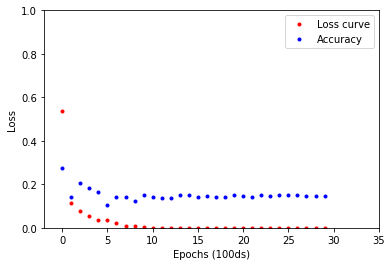

Finished Training


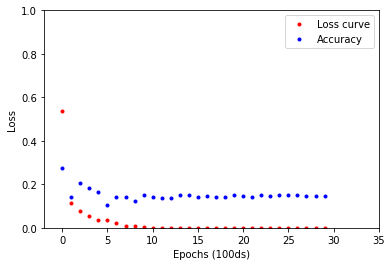

In [23]:
Tot_Loss = []
Accuracy = []
sizeTrain = len(train_loader)
MaxEpochs = 30

for epoch in range(MaxEpochs):  # loop over the dataset multiple times
    
    epoch_loss = 0
    running_loss = 0.0
    
    # Dynamic Learning Rate
    # adjust_learning_rate(optimizer, epoch)
    
    print('epoch = ', epoch, end = ' ')
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # print('inputs.shape = ',inputs.shape )
        labels = torch.Tensor.long(labels).to(device)
        inputs = inputs.to(device)
        # print('labels  = ',labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # print(' LOSS   = ',loss)
        loss.backward()
        optimizer.step()

        
        # print statistics
        running_loss += loss.item()
        
        if i % 100 == 0:
            print('.', end ='')

    epoch_loss = running_loss/sizeTrain
    Tot_Loss.append(epoch_loss)
    
    # Computing Accuracy on Test Data:
    
    correct = 0
    total = 0
    #print('test_loader len = ',len(test_loader))
    with torch.no_grad():
        for index, val_data in enumerate(test_loader):  # index runs up to 8 and jumps to 300 thereafter
            #print('index  = ', index, end='  ')
            val_images, val_labels = val_data
            val_labels = torch.Tensor.long(val_labels).to(device)
            val_images = val_images.to(device)
            #print('val_labels  ', val_labels, end='  ')
            val_outputs = net(val_images)
            stam, predicted = torch.max(val_outputs.data, 1)
            #print('softmax result =',stam)
            #print('PlantIdxes   = ',val_idx, end='  ')
            #print(' predicted =',predicted)
            total += val_labels.size(0)
            temp = (predicted == val_labels)
            correct +=  1*temp[0].item()+1*temp[1].item()+1*temp[2].item()+1*temp[3].item()
            
    Accuracy.append(correct / total)
    
    # Dynamic plotting
    pl.clf()
    pl.plot(Tot_Loss,'.r', label='Loss curve')
    pl.plot(Accuracy,'.b', label='Accuracy')
    pl.xlabel('Epochs (100ds)')
    pl.ylabel('Loss')
    pl.ylim([0.0, 1.0])
    pl.xlim([-2.0, MaxEpochs+5.0])
    pl.legend(loc="upper right")
    display.clear_output(wait=False)
    display.display(pl.gcf())
        
print('Finished Training')

In [24]:
print('Accuracy type is: ',type(Accuracy[0]))
print('correct type is: ',type(correct))
print('total type is: ',type(total))

Accuracy type is:  <class 'float'>
correct type is:  <class 'int'>
total type is:  <class 'int'>


In [28]:
print(correct)

256


In [ ]:
print(val_labels)

In [ ]:
print(predicted == val_labels)

In [ ]:
aaa= (predicted == val_labels)

In [ ]:
aaa

In [ ]:
aaa[0].item()*aaa[1].item()*aaa[2].item()*aaa[3].item()*1

In [29]:
print(total)

1732


In [30]:
 !jupyter nbconvert --to python 2Exp3ColorPlantClassification.ipynb

[NbConvertApp] Converting notebook 2Exp3ColorPlantClassification.ipynb to python
[NbConvertApp] Writing 8718 bytes to 2Exp3ColorPlantClassification.py


In [1]:
labels = (
        3, 11, 6, 5, 4,
        3, 11, 6, 5, 4,
        3, 4, 6, 5, 11,
        3, 4, 5, 6, 11,
        3, 4, 5, 6, 11,
        3, 4, 5, 6, 11
    )

In [12]:
import numpy as  np

In [17]:
class_numbers   =  [3, 4, 5, 6, 11]
new_class_enumeration  =  [0, 1, 2, 3, 4]

In [9]:
targets   =  [3, 11, 6, 5, 4, 3, 11, 6, 5, 4, 3, 4, 6, 5, 11, 3, 4, 5, 6, 11, 3, 4, 5, 6, 11, 3, 4, 5, 6, 11, 3, 11, 6, 5, 4, 3, 11, 6, 5, 4, 3, 4, 6, 5, 11, 3, 4, 5, 6, 11, 3, 4, 5, 6, 11, 3, 4, 5, 6, 11, 3, 11, 6, 5, 4, 3, 11, 6, 5, 4, 3, 4, 6, 5, 11, 3, 4, 5, 6, 11, 3, 4, 5, 6, 11, 3, 4, 5, 6, 11, 3, 11, 6, 5, 4, 3, 11, 6, 5, 4, 3, 4, 6, 5, 11, 3, 4, 5, 6, 11, 3, 4, 5, 6, 11, 3, 4, 5, 6, 11, 3, 11, 6, 5, 4, 3, 11, 6, 5, 4, 3, 4, 6, 5, 11, 3, 4, 5, 6, 11, 3, 4, 5, 6, 11, 3, 4, 5, 6, 11, 3, 11, 6, 5, 4, 3, 11, 6, 5, 4, 3, 4, 6, 5, 11, 3, 4, 5, 6, 11, 3, 4, 5, 6, 11, 3, 4, 5, 6, 11, 3, 11, 6, 5, 4, 3, 11, 6, 5, 4, 3, 4, 6, 5, 11, 3, 4, 5, 6, 11, 3, 4, 5, 6, 11, 3, 4, 5, 6, 11]

In [22]:
rev = dict(zip(class_numbers, new_class_enumeration))
rev

{3: 0, 4: 1, 5: 2, 6: 3, 11: 4}

In [25]:
new_targets = [rev.get(item,item)  for item in targets]
new_targets

[0,
 4,
 3,
 2,
 1,
 0,
 4,
 3,
 2,
 1,
 0,
 1,
 3,
 2,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 4,
 3,
 2,
 1,
 0,
 4,
 3,
 2,
 1,
 0,
 1,
 3,
 2,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 4,
 3,
 2,
 1,
 0,
 4,
 3,
 2,
 1,
 0,
 1,
 3,
 2,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 4,
 3,
 2,
 1,
 0,
 4,
 3,
 2,
 1,
 0,
 1,
 3,
 2,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 4,
 3,
 2,
 1,
 0,
 4,
 3,
 2,
 1,
 0,
 1,
 3,
 2,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 4,
 3,
 2,
 1,
 0,
 4,
 3,
 2,
 1,
 0,
 1,
 3,
 2,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 4,
 3,
 2,
 1,
 0,
 4,
 3,
 2,
 1,
 0,
 1,
 3,
 2,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4]

In [27]:
new_targets[19]

4